<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/RTM_ML_Predicting_a_raster_downloaded_from_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#First lets download the image from google earth engine, cropped to an AOI

In [0]:
import ee

In [13]:
#then we need to authenticate

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/vwHeBjdQnB8HRte4gjBOb-8Sp3KV_h1d-AudFYYE-vUMhZg9ROrwPoI

Successfully saved authorization token.


In [14]:
#then we need to authenticate in google drive also so we can upload our download there

from google.colab import drive
drive.mount('/content/drive')
#Perhaps this step can be skipped by saving directly to the workspace

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Let's do a quick search on the data collection of Sentinel

check this for info how to:

https://samapriya.github.io/gee-py/projects/collection_meta/
https://stackoverflow.com/questions/57841300/export-google-earth-engine-rgb-sentinel-2-imagery-to-google-drive-using-python-a



In [15]:
#This creates a polygon area which perhaps we can use as a filter
#this next step actually clips the image 
#this is a polygon area created by me, it surrounds the park, perhaps there are better ways of designing this also
poly_area_coord = [[[5.254370219641714,52.41249485115749],
                    [5.423285014563589,52.41249485115749],
                    [5.423285014563589,52.49910845916859],
                    [5.254370219641714,52.49910845916859],
                    [5.254370219641714,52.41249485115749]]]

poly_area = ee.Geometry.Polygon(poly_area_coord)

# it is quite COMPLEX to use the s2 filters in python
s2_collection = (ee.ImageCollection("COPERNICUS/S2_SR") #selects the S2 Surface reflectance product in GEE
                 .select(['B2','B3','B4',
                          'B5','B6','B7',
                          'B8A','B11','B12']) #selects the bands of interest
                 .filter(ee.Filter.date('2019-07-15','2019-10-30')) #filtes on the time
                 .filterBounds(poly_area) #filters on the Aoi
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)))


count = s2_collection.size()
print('Nr of images in collection: ', str(count.getInfo())+'\n')

import pprint
pp = pprint.PrettyPrinter(depth=4)
#pp.pprint('Collection: '+str(s2_collection.getInfo())+'\n')
pp.pprint('Collection: '+str(s2_collection.name())+'\n')

#couldn't find an easy way to print the image date... yet.. which is kinda annoying

#bb= s2_collection.iterate()
#print(bb)
#print(s2_collection.getInfo())
#s2_collection = ee.ImageCollection("COPERNICUS/S2_SR/").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10),
#                                                               ee.filter('time','2019-07-15','2019-07-20'),
#                                                               ee.filterBounds(poly_area))
#s2_collection.filter(ee.filter("time",'2019-07-15','2019-07-20'))
#s2_collection = ee.collection.filter(ee.Filter())
#ee.ImageCollection(ee.Filter)

Nr of images in collection:  4

'Collection: ImageCollection\n'


In [0]:
#this loads a pre-selected image, i reckon it can be a loop - this data is TOA
s2_img = ee.Image("COPERNICUS/S2/20190717T104029_20190717T104353_T31UFU").select(['B2','B3','B4',
                                                                                  'B5','B6','B7',
                                                                                  'B8A','B11','B12'])

#this on is suppose to be the surface reflectance
s2_img = ee.Image("COPERNICUS/S2_SR/20190717T104029_20190717T104353_T31UFU").select(['B2','B3','B4',
                                                                                  'B5','B6','B7',
                                                                                  'B8A','B11','B12'])


#this selects an miage from the above list, change here to get the other data on the list
mid_step = s2_collection.toList(count)
s2_img = ee.Image(mid_step.get(1))



#In the next part, its possible to explore the selected image

In [18]:
#first step now is to then generate a s2 image cropped to our aoi, and for information i will also plot it on the map

# Import the Folium library. This library is to assist in visualizations
import folium

# Import the Image function from the IPython.display module. 
from IPython.display import Image


#the next code snippet i stole from someone
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
visParams = {"bands": ['B4', 'B3', 'B2'],"gain": '0.1, 0.1, 0.1',"scale":20}

# Create a folium map object.
my_map = folium.Map(location=[52.4500, 5.35], zoom_start=12) #this had to be tried one by one... feels daft

# Add the elevation model to the map object.
my_map.add_ee_layer(s2_img, visParams, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

#Lets try to fetch the metadata of the image so we can use the info to run the prosail later on


In [0]:
#s2_img.getInfo() #this gives me the info

s2_img_meta = s2_img.getInfo()
#type(s2_img_meta)
#s2_img_meta


The data is stored in a nested dictionary, to fetch it we should call it as the following example. 

I'm using it also to call some examples to help me keep track of what is going on

In [22]:
#it is a nested dictionary, so we have to get into get
print('System index: ',s2_img_meta.get('properties',{}).get('system:index'))
print('Product ID: ',s2_img_meta.get('properties',{}).get('PRODUCT_ID'))
print('Granule ID: ',s2_img_meta.get('properties',{}).get('GRANULE_ID'))
print('Quick for GEE: ',s2_img_meta.get('id')) #use this text to call the image straight through GEE, its the easiest

#i dont seem to be able to find the command to get the date 
#dates = s2_collection.aggregate_array("system:time_start")
#ee.Date(s2_img)
#bb = ee.List(s2_collection.aggregate_array("system:time_start"))
#print(bb)

System index:  20190730T105039_20190730T105502_T31UFU
Product ID:  S2B_MSIL2A_20190730T105039_N0213_R051_T31UFU_20190730T140936
Granule ID:  L2A_T31UFU_A012518_20190730T105502
Quick for GEE:  COPERNICUS/S2_SR/20190730T105039_20190730T105502_T31UFU


On the other hand, we have slightly different mean incidence angles per band, to facilitate i will use a mean of means for each band

In [23]:
#each band has its own "mean angle", fors this run i will cheat and use an approximate
#we used the following bands:
#'B2','B3','B4','B5','B6','B7','B8A','B11','B12'

#e.g.
print(s2_img_meta.get('properties',{}).get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B2'))

#the easiest way is perhaps to just loop
band_list = ['B2','B3','B4','B5','B6','B7','B8A','B11','B12']
inc_azi = 0 #starting value
inc_zen = 0
for i in band_list:
  #print('MEAN_INCIDENCE_AZIMUTH_ANGLE_'+i)
  #print(s2_img_meta.get('properties',{}).get('MEAN_INCIDENCE_AZIMUTH_ANGLE_'+i))
  inc_azi = inc_azi + s2_img_meta.get('properties',{}).get('MEAN_INCIDENCE_AZIMUTH_ANGLE_'+i)/len(band_list)
  inc_zen = inc_zen + s2_img_meta.get('properties',{}).get('MEAN_INCIDENCE_ZENITH_ANGLE_'+i)/len(band_list)

#relative to the sensor positions
print("mean incidence azimuth of selected bands:", inc_azi)
print("mean incidence zenith of selected bands:", inc_zen)

#relative to the solar position
sol_azi = s2_img_meta.get('properties',{}).get('MEAN_SOLAR_AZIMUTH_ANGLE')
sol_zen = s2_img_meta.get('properties',{}).get('MEAN_SOLAR_ZENITH_ANGLE')

print("mean solar azimuth:", inc_azi)
print("mean solar zenith:", inc_zen)

#inputs for prosail are then
#sza, vza and raa are the solar zenith, sensor zenith and relative azimuth angles
sza = sol_zen
vza = inc_zen
raa = sol_zen - inc_zen #is this correct? im not so sure 

print("Prosail inputs:")
print("sza:",sza)
print("vza:",vza)
print("raa",raa)


237.849869313
mean incidence azimuth of selected bands: 233.52216397555551
mean incidence zenith of selected bands: 3.5249383513266666
mean solar azimuth: 233.52216397555551
mean solar zenith: 3.5249383513266666
Prosail inputs:
sza: 35.5167698265
vza: 3.5249383513266666
raa 31.991831475173335


#Now we will clip the image before processing

The polygon for clipping was defined earlier. 

In [0]:

#the ideal would be to find a way to extract a date in YYYYMMDD format and automate that for the file naming

#GEE requires a client task to be called, here it goes

#this is a dictionary object with the details for the batch export function off GEE
#it will save  the data to my drive
task_config = {
    'image': s2_img,
    'fileFormat': 'GeoTIFF',
    'fileNamePrefix': 'S2_ML_Data_SR_20190730',
    'description': 'S2_ML_Data_SR_20190730',
    'scale':20,
    'region':poly_area
}
#this starts the task - notice that it has to be called and then wait.
#since it is an operation ongoing on GEE, python will not produce any error message
#if omething is wrong. The commands in the next section show how to check on that 
task = ee.batch.Export.image.toDrive(**task_config )
task.start()


The next two code snippets allow us to keep track of the procedure

In [28]:
task.status()

{'creation_timestamp_ms': 1580140536736,
 'description': 'S2_ML_Data_SR_20190730',
 'id': '35BIXHDGORQLPTGXBIMMFIPC',
 'name': 'projects/earthengine-legacy/operations/35BIXHDGORQLPTGXBIMMFIPC',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1580140536736}

In [31]:
task.active()

False

#now have uploaded the image to my drive, lets try to visualize it in python now



In [30]:
!pip install pyrsgis
!pip install rasterio
!pip install pyproj

     |████████████████████████████████| 18.0MB 207kB/s 
     |████████████████████████████████| 10.1MB 3.4MB/s 


In [32]:
#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

import os
from pyrsgis import raster

import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt



Warning! matplotlib_scalebar library not found.


The easiest for now is actually downloading the file, and uploading it again. There must be better alternatives. 

In [145]:
#This loads the data
s2_data = 'drive/My Drive/S2_ML_Data_SR_20190730.tif'

ds1, bands = raster.read(s2_data)
print(ds1)
print(bands.shape) #the raster has 9 bands by 501 x 590 (not sure wich is the row)

from pyrsgis.convert import changeDimension

#this function converts the hypercube to a 2D array


bandByPixel = changeDimension(bands)/10000. #we have to devide all values by 10k - its a conversion from bits to reflectances
bandByPixel_t = np.transpose(bandByPixel)
print(bandByPixel.shape)
print(bandByPixel_t.shape)
bandByPixel

import scipy
from scipy import stats
print(scipy.stats.describe(changeDimension(bands)))
print(scipy.stats.describe(bandByPixel))

(9, 501, 590)
(295590, 9)
(9, 295590)
DescribeResult(nobs=295590, minmax=(array([174, 202, 114,  93,  52,  39,  41,   1,  19]), array([5779, 5832, 5780, 5918, 5705, 6260, 6344, 6343, 6703])), mean=array([ 519.81046382,  749.79437396,  534.68045942,  865.71188132,
       1701.63960892, 2068.88501641, 2159.593129  , 1108.95873   ,
        610.06171048]), variance=array([  72871.61110946,   72606.65849827,  103219.10425434,
        169974.65711976, 1761796.23184308, 2916830.90732733,
       3536706.32641895,  975605.51072441,  329986.55273146]), skewness=array([9.43797997, 8.03398607, 5.99630858, 2.27678545, 0.274878  ,
       0.32653829, 0.2904653 , 0.33078494, 1.46938936]), kurtosis=array([119.04549709,  95.80278192,  53.94076852,  13.98334539,
        -1.41003809,  -1.42240865,  -1.53586955,  -1.19084864,
         3.92401977]))
DescribeResult(nobs=295590, minmax=(array([0.0174, 0.0202, 0.0114, 0.0093, 0.0052, 0.0039, 0.0041, 0.0001,
       0.0019]), array([0.5779, 0.5832, 0.578 , 0.591

Link of interest:

https://geohackweek.github.io/raster/04-workingwithrasters/


https://www.hatarilabs.com/ih-en/sentinel2-images-explotarion-and-processing-with-python-and-rasterio

Text(0, 0.5, 'Row #')

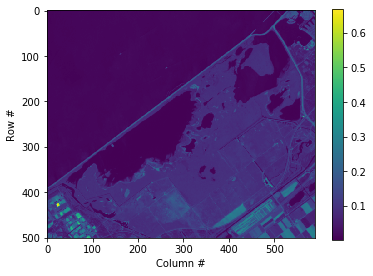

In [34]:
#window = rasterio.windows.Window(1024, 1024, 1280, 2560)
with rasterio.open(s2_data) as src:
    subset = src.read(9)/10000.

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
#plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

#now sure i know how to produce a RGB for now but it doesn't matter,
# this is just to show i have cropped the image


#now we will quickly set up a GPR trained on PROSAIL to try the model

In [35]:
#Installing PROSAIL
!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
!pip install pysptools

In [0]:
import pandas as pd
import numpy as np

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

The next functions are helper functions to facilitate the calls

In [0]:
def custom_prosail(cab,cw,cm,lai):
  import prosail
  #default parameters
  n= 1.2
  car=25.
  cbrown=0.01
  typelidf=1
  lidfa = -0.35 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot= 0.01 #hotspot parameters
  #sun and viewing angle
  #tts=30. #observation and solar position parameters
  #tto=10. 
  #psi=0.
  #for now i put them by hand but they should be an input of a custom function
  tts=sza
  tto=vza 
  psi=raa
  rho_out = prosail.run_prosail(n,
                                 cab,
                                 car,
                                 cbrown,
                                 cw,
                                 cm,
                                 lai,
                                 lidfa,hspot,tts,tto,psi,
                                 typelidf, #lidfb=-0.15,
                                 factor='SDR', rsoil=1., psoil=1.)
  return(rho_out)

In [0]:
def Prosail2S2(path2csv,spectra_input):
  #importing pandas
  import pandas as pd
  import numpy
  import numpy as np
  #upload a S2_Response.csv from https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses

  s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec

  s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
  spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
  rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
  w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

  output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

  return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/content/S2_Response.csv"


In [0]:
def Gen_spectra_data(traits):
  k = 1
  #pd_train_traits=traits
  #print(range(len(traits)))
  for i in range(len(traits)):
    #n_t = pd_train_traits["n"][i]
    cab_t = traits["cab"][i]
    #car_t = pd_train_traits["car"][i]
    #cbrown_t = pd_train_traits["cbrown"][i]
    cw_t = traits["cw"][i]
    cm_t = traits["cm"][i]
    lai_t = traits["lai"][i]

    if k == 1:
      tr_rho_s = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_s = Prosail2S2(filepath,tr_rho_s)
      #plt.plot ( x, tr_rho_s, ':', label="Training prosail")
      #plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_t = Prosail2S2(filepath,tr_rho_t)
      tr_rho_s = np.vstack((tr_rho_s,tr_rho_t))
      #plt.plot ( x, tr_rho_t, ':')

    k = k+1


  rho_samples=tr_rho_s


  return rho_samples


#preparing the input data for prosail

In [0]:
#number of samples
train_n3000 = 3000

n_traits=4 #I will test on 4 varying traits: cab, car, cw,cm,lai

#generating a LHS hypercube (it uses a 0 to 1 interval that can be used as a multiplier against the different traits)
np.random.seed(0)
LHS_train3000 = lhsmdu.createRandomStandardUniformMatrix(n_traits,train_n3000 ) #the package has a more advanced method but it is too slow to process

#max_n=1 #this value should go from 1 to 2, so i make it change from 0 to 1 here and then add 1 later
max_cab=120. #add 1
#max_car=44. #add 1
#max_cbrown= 9.99 #add 0.01
max_cw=0.01 #0.008 #add 0.001 
max_cm=0.01 #0.008 #0.001
max_lai = 9.9 #add 0.1


min_cab = 1.
min_cw = 0.001
min_cm = 0.001
min_lai = .1

In [0]:
#preparing function inputs


pd_traits3000 = pd.DataFrame.transpose(pd.DataFrame(LHS_train3000))
pd_traits3000.columns = ["cab","cw","cm","lai"]

pd_traits3000["cab"]=pd_traits3000["cab"]*max_cab+min_cab
pd_traits3000["cw"] =pd_traits3000["cw"] *max_cw +min_cw
pd_traits3000["cm"] =pd_traits3000["cm"] *max_cm +min_cm
pd_traits3000["lai"]=pd_traits3000["lai"]*max_lai+min_lai

np_spectra3000 = Gen_spectra_data(pd_traits3000)


In [148]:
print(np_spectra3000.shape)
#lets also create a numpy object for the tratis
np_traits3000 = pd_traits3000.iloc[:,:].values

train_df_3000 = np_spectra3000[:,[1,2,3,4,5,6,8,11,12]]
print(train_df_3000.shape)

X_train = train_df_3000
Y_train = np_traits3000

(3000, 13)
(3000, 9)


In [149]:
scipy.stats.describe(X_train)

DescribeResult(nobs=3000, minmax=(array([0.02097415, 0.01916305, 0.01896564, 0.02958633, 0.30402084,
       0.38785268, 0.41985631, 0.23030916, 0.07199021]), array([0.19418458, 0.38871658, 0.34469618, 0.55868118, 0.7209047 ,
       0.77448025, 0.78205412, 0.59579684, 0.47870123])), mean=array([0.03062025, 0.06714546, 0.04399716, 0.11119218, 0.41973868,
       0.56273157, 0.57143518, 0.35860127, 0.1741946 ]), variance=array([0.0006907 , 0.00420063, 0.00264957, 0.00894812, 0.00534661,
       0.00655449, 0.00598861, 0.00517722, 0.00632396]), skewness=array([3.75807449, 1.94308055, 2.78124008, 1.68787827, 0.94084357,
       0.27810468, 0.44596012, 0.56188946, 1.34196048]), kurtosis=array([14.33248858,  3.57495462,  7.76073126,  2.60992634,  0.53054341,
       -0.35963821, -0.38301751, -0.25029621,  1.45047053]))

#time for training and predicting the GPR

In [150]:
#Gaussian processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

gpr_ml = GaussianProcessRegressor(n_restarts_optimizer=50,
                                        normalize_y=True,
                                        random_state=0)#,copy_X_train=False)


#GPR - Training 
gpr_ml.fit(X_train,Y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=50, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=0)

Let's do a quick test to see how it works against simulated data

In [151]:
LHS_valid0500 = lhsmdu.createRandomStandardUniformMatrix(n_traits,500) #the package has a more advanced method but it is too slow to process


pd_valid0500 = pd.DataFrame.transpose(pd.DataFrame(LHS_valid0500))
pd_valid0500.columns = ["cab","cw","cm","lai"]

pd_valid0500["cab"]=pd_valid0500["cab"]*max_cab+min_cab
pd_valid0500["cw"] =pd_valid0500["cw"] *max_cw +min_cw
pd_valid0500["cm"] =pd_valid0500["cm"] *max_cm +min_cm
pd_valid0500["lai"]=pd_valid0500["lai"]*max_lai+min_lai

np_spectra0500 = Gen_spectra_data(pd_valid0500)

print(np_spectra0500.shape)
#lets also create a numpy object for the tratis
np_valid0500 = pd_valid0500.iloc[:,:].values

valid_df_0500 = np_spectra0500[:,[1,2,3,4,5,6,8,11,12]]
print(valid_df_0500.shape)



(500, 13)
(500, 9)


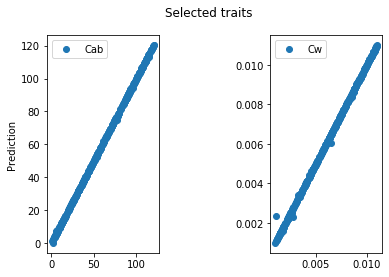

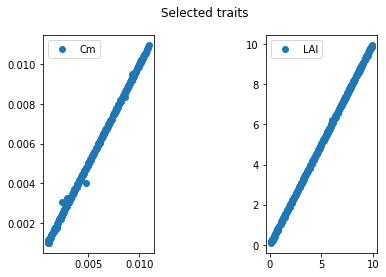

In [152]:
test_pred = gpr_ml.predict(valid_df_0500)

#plotting cab
fig, axs = plt.subplots(1,2)
fig.suptitle('Selected traits')
fig.subplots_adjust(wspace=1)

#plt.subplot(3,1,1)
axs[0].plot(pd_valid0500["cab"],test_pred[:,0],"o",label="Cab")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")

axs[1].plot(pd_valid0500["cw"],test_pred[:,1],"o",label="Cw")
axs[1].legend(loc="upper left")
#axs[1].set_ylabel("Prediction")

plt.show()

#plotting cab
fig, axs = plt.subplots(1,2)
fig.suptitle('Selected traits')
fig.subplots_adjust(wspace=1)


axs[0].plot(pd_valid0500["cm"],test_pred[:,2],"o",label="Cm")
axs[0].legend(loc="upper left")
#axs[0].set_ylabel("Prediction")

axs[1].plot(pd_valid0500["lai"],test_pred[:,3],"o",label="LAI")
axs[1].legend(loc="upper left")
#axs[3].set_ylabel("Prediction")

Checking the data before the predictions



In [153]:
print("Stats of input train data")
print(scipy.stats.describe(X_train))

print("Stats of input s2 data")
print(scipy.stats.describe(bandByPixel))

#this comparision does not make much sense because i will have data that is objectively not even vegetation... 

Stats of input train data
DescribeResult(nobs=3000, minmax=(array([0.02097415, 0.01916305, 0.01896564, 0.02958633, 0.30402084,
       0.38785268, 0.41985631, 0.23030916, 0.07199021]), array([0.19418458, 0.38871658, 0.34469618, 0.55868118, 0.7209047 ,
       0.77448025, 0.78205412, 0.59579684, 0.47870123])), mean=array([0.03062025, 0.06714546, 0.04399716, 0.11119218, 0.41973868,
       0.56273157, 0.57143518, 0.35860127, 0.1741946 ]), variance=array([0.0006907 , 0.00420063, 0.00264957, 0.00894812, 0.00534661,
       0.00655449, 0.00598861, 0.00517722, 0.00632396]), skewness=array([3.75807449, 1.94308055, 2.78124008, 1.68787827, 0.94084357,
       0.27810468, 0.44596012, 0.56188946, 1.34196048]), kurtosis=array([14.33248858,  3.57495462,  7.76073126,  2.60992634,  0.53054341,
       -0.35963821, -0.38301751, -0.25029621,  1.45047053]))
Stats of input s2 data
DescribeResult(nobs=295590, minmax=(array([0.0174, 0.0202, 0.0114, 0.0093, 0.0052, 0.0039, 0.0041, 0.0001,
       0.0019]), array([

The prediction runs out of RAM unfortunately


In [0]:
#this predicts the data back into the pixel data (its not fast)
#img_pred = gpr_ml.predict(bandByPixel)

lets see what we ahve 

In [155]:
print(bandByPixel.shape)
print(train_df_3000.shape)

#lets split it into folds and solve it by a loop
from sklearn.model_selection import KFold
kf = KFold(n_splits=30)
kf.split(bandByPixel)



k=1
for i,j in kf.split(bandByPixel):
  #print(i.shape)
  #print(j.shape)
  
  print(k)
  
  X_test = bandByPixel[j] #this fetches the rows on the test section

  print(X_test.shape)
  print("end of fold")

  temp_pred = gpr_ml.predict(X_test)

  if k == 1: 
    out_stack = temp_pred
  if k > 1:
    out_stack = np.vstack((out_stack,temp_pred))


  k=k+1



(295590, 9)
(3000, 9)
1
(9853, 9)
end of fold
2
(9853, 9)
end of fold
3
(9853, 9)
end of fold
4
(9853, 9)
end of fold
5
(9853, 9)
end of fold
6
(9853, 9)
end of fold
7
(9853, 9)
end of fold
8
(9853, 9)
end of fold
9
(9853, 9)
end of fold
10
(9853, 9)
end of fold
11
(9853, 9)
end of fold
12
(9853, 9)
end of fold
13
(9853, 9)
end of fold
14
(9853, 9)
end of fold
15
(9853, 9)
end of fold
16
(9853, 9)
end of fold
17
(9853, 9)
end of fold
18
(9853, 9)
end of fold
19
(9853, 9)
end of fold
20
(9853, 9)
end of fold
21
(9853, 9)
end of fold
22
(9853, 9)
end of fold
23
(9853, 9)
end of fold
24
(9853, 9)
end of fold
25
(9853, 9)
end of fold
26
(9853, 9)
end of fold
27
(9853, 9)
end of fold
28
(9853, 9)
end of fold
29
(9853, 9)
end of fold
30
(9853, 9)
end of fold


Seems it's a sucess!

In [131]:
print(out_stack.shape)

(295590, 4)


In [132]:
print(out_stack)

[[ 4.96942588e+02 -7.68130645e-03  2.36228831e-01  9.46329323e+01]
 [ 4.92644948e+02 -7.35222198e-03  2.35671703e-01  9.66294139e+01]
 [ 4.90669546e+02 -7.67302792e-03  2.32759030e-01  9.49727999e+01]
 ...
 [-1.41924403e+02 -2.63502996e-02  9.50855294e-03 -1.56591755e+02]
 [-9.26202570e+01 -2.98264530e-02  1.69613777e-02 -1.73167499e+02]
 [-1.38563672e+02 -3.32965886e-02  1.37610428e-02 -1.87606471e+02]]


Final set up before saving

In [156]:
print(pd_traits3000)


cab_band = out_stack[:,0]
cw_band = out_stack[:,1]
cm_band = out_stack[:,2]
lai_band = out_stack[:,3]


cab_img = np.reshape(cab_band,(ds1.RasterYSize,ds1.RasterXSize))
cm_img = np.reshape(cm_band,(ds1.RasterYSize,ds1.RasterXSize))
cw_img = np.reshape(cw_band,(ds1.RasterYSize,ds1.RasterXSize))
lai_img = np.reshape(lai_band,(ds1.RasterYSize,ds1.RasterXSize))

#and now we can save it to a raster file
cab_outfile = "s2_cab_sr_201907301_3.tif"
cm_outfile = "s2_cm_sr_20190730_3.tif"
cw_outfile = "s2_cw_sr_20190730_3.tif"
lai_outfile = "s2_lai_sr_20190730_3.tif"


scipy.stats.describe(out_stack)

             cab        cw        cm       lai
0      66.857620  0.005140  0.004748  6.403285
1      86.822724  0.007296  0.005287  9.010451
2      73.331605  0.008786  0.007831  7.762132
3      66.385982  0.009516  0.007009  1.375767
4      51.838576  0.009164  0.001705  0.759908
...          ...       ...       ...       ...
2995  114.002449  0.002042  0.006134  5.034956
2996   66.535930  0.002395  0.001722  1.305441
2997   39.833645  0.007965  0.001692  8.450461
2998   98.625402  0.005837  0.008581  9.434802
2999   84.688045  0.004396  0.010320  8.344942

[3000 rows x 4 columns]


DescribeResult(nobs=295590, minmax=(array([-3.96101170e+03, -1.74944286e-01, -1.74721734e+00, -2.41921130e+02]), array([1.09809147e+03, 3.22735499e+00, 4.98820334e-01, 1.01517425e+03])), mean=array([2.29159014e+02, 1.68495130e-02, 1.08712549e-01, 2.51534737e+01]), variance=array([2.81557990e+04, 3.77609350e-03, 9.31829746e-03, 6.75681863e+03]), skewness=array([-0.86459129, 21.03723323, -0.1595231 ,  1.72695493]), kurtosis=array([ 15.74315289, 585.90367552,   1.44898986,  15.70026546]))

In [0]:
raster.export(cab_img, ds1, cab_outfile, dtype='float')
raster.export(cm_img, ds1, cm_outfile, dtype='float')
raster.export(cw_img, ds1, cw_outfile, dtype='float')
raster.export(lai_img, ds1, lai_outfile, dtype='float')

IT worked but the results are nonsense:

The GPR is predicting quite well on the simulated data but fails completely on the real satellite data.. 

Options: 

- perhaps the function to transform hyperspectral to sentinel data is improper
- overfitting of the ML?
- something wrong on the SR data? am i putting in the right inputs?




Text(0, 0.5, 'Row #')

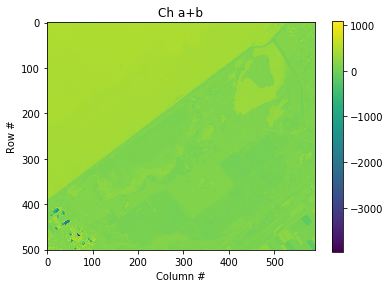

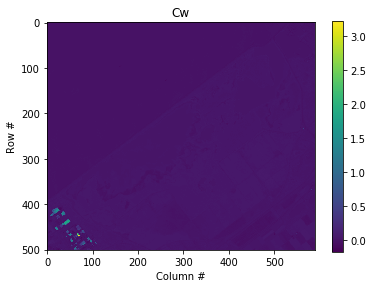

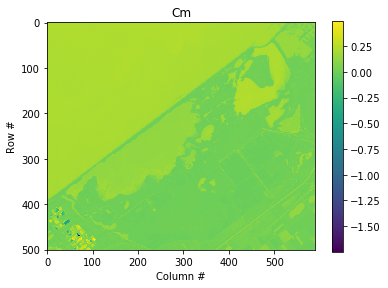

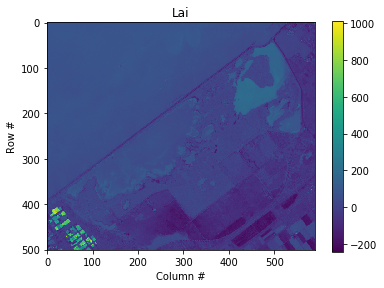

In [158]:
#window = rasterio.windows.Window(1024, 1024, 1280, 2560)

#in a GIS we can easily change the color scale to avoid the extremes

plt.figure(figsize=(6,8.5))
plt.imshow(cab_img)
plt.colorbar(shrink=0.5)
plt.title('Ch a+b')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.figure(figsize=(6,8.5))
plt.imshow(cw_img)
plt.colorbar(shrink=0.5)
plt.title('Cw')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.figure(figsize=(6,8.5))
plt.imshow(cm_img)
plt.colorbar(shrink=0.5)
plt.title('Cm')
plt.xlabel('Column #')
plt.ylabel('Row #')


plt.figure(figsize=(6,8.5))
plt.imshow(lai_img)
plt.colorbar(shrink=0.5)
plt.title('Lai')
plt.xlabel('Column #')
plt.ylabel('Row #')
